In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.data_wrangling as data
import functions.eddy_feedback as ef

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

![DivF.png](DivF.png)

# CanESM5

In [2]:
# can_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/CanESM5/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)
# can_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/CanESM5/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)

# can_epfy = can_epfy.sel( plev = can_ua.plev.values )
# can_ds = xr.Dataset( {'ubar': can_ua.ua.mean('lon'), 'epfy': can_epfy.epfy})
# can_ds = can_ds.rename({'plev': 'level'})
# can_ds = can_ds.sel(time=slice('2000-06', '2001-05'))

can_ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/CanESM5*.nc',
                           parallel=True, chunks={'time':12, 'ens_ax':150})

can_ds

<xarray.Dataset>
Dimensions:  (ens_ax: 300, time: 12, level: 19, lat: 61)
Coordinates:
  * time     (time) object 2000-06-16 00:00:00 ... 2001-05-16 12:00:00
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>
    divF     (ens_ax, time, level, lat) float64 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>

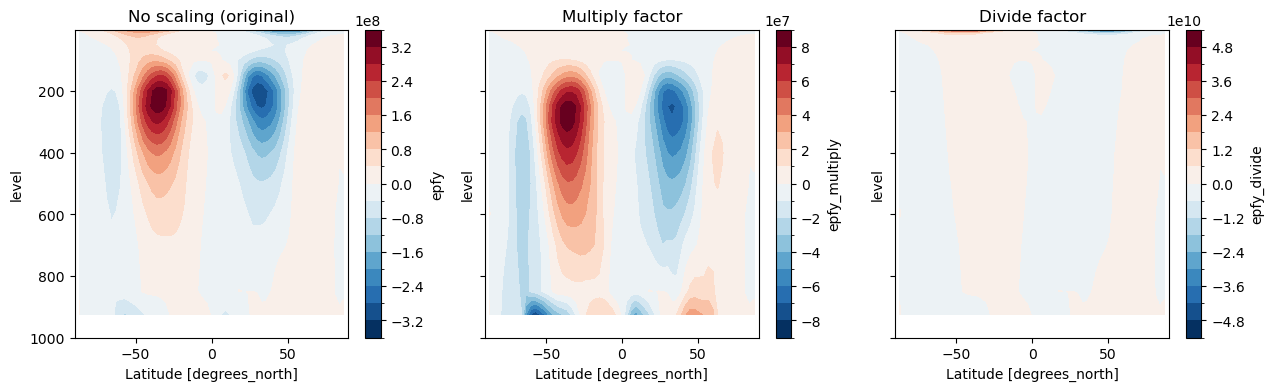

In [3]:
# define factor variables
can_ds['epfy_multiply'] = ef.pressure_scaling(can_ds['epfy'], multiply_factor=True)
can_ds['epfy_divide'] = ef.pressure_scaling(can_ds['epfy'], multiply_factor=False)

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
can_ds.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
can_ds.epfy_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
can_ds.epfy_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

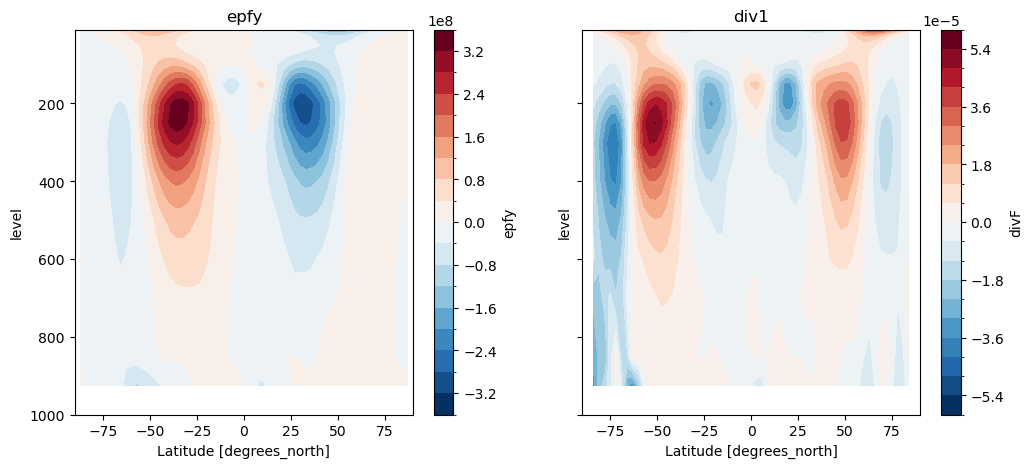

In [4]:
# calculate divFphi and insert into dataset
can_ds = ef.calculate_divFphi(can_ds, which_Fphi='epfy', apply_scaling=False)
can_ds = ef.calculate_divFphi(can_ds, which_Fphi='epfy_divide', apply_scaling=False, save_divFphi='divF_divide')
can_ds = ef.calculate_divFphi(can_ds, which_Fphi='epfy_multiply', apply_scaling=False, save_divFphi='divF_multiply')

# plot original variables
can_ds1 = can_ds.sel(level=slice(1000,10))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
can_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
can_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

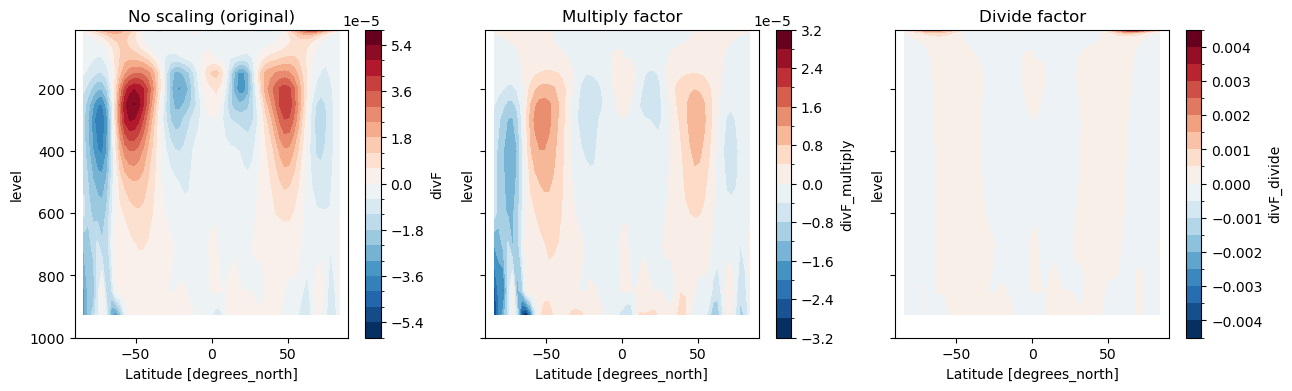

In [5]:
can_ds1 = can_ds.sel(level=slice(1000., 10.))

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
can_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
can_ds1.divF_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
can_ds1.divF_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

### Eddy Feedback Parameter

In [6]:
# calculate NH EFP
can_efp_multiply_south = ef.calculate_efp_pamip(can_ds, which_div1='divF_multiply', calc_south_hemis=True)
can_efp_divide_south = ef.calculate_efp_pamip(can_ds, which_div1='divF_divide', calc_south_hemis=True)
can_efp_south = ef.calculate_efp_pamip(can_ds, calc_south_hemis=True)

# calculate SH EFP
can_efp_multiply = ef.calculate_efp_pamip(can_ds, which_div1='divF_multiply')
can_efp_divide = ef.calculate_efp_pamip(can_ds, which_div1='divF_divide')
can_efp = ef.calculate_efp_pamip(can_ds)

print('CanESM5 DJF Feedback:\n')
print(f'Multiplying factor: {can_efp_multiply} \nDividing factor: {can_efp_divide} \nNo factor: {can_efp}')
print('\nCanESM5 JAS Feedback:\n')
print(f'Multiplying factor: {can_efp_multiply_south} \nDividing factor: {can_efp_divide_south} \nNo factor: {can_efp_south}')

CanESM5 DJF Feedback:

Multiplying factor: 0.4255 
Dividing factor: 0.4255 
No factor: 0.4255

CanESM5 JAS Feedback:

Multiplying factor: 0.4634 
Dividing factor: 0.4634 
No factor: 0.4634


# CESM2

CESM2 DJF Feedback: 0.3978
CESM2 JAS Feedback: 0.3548


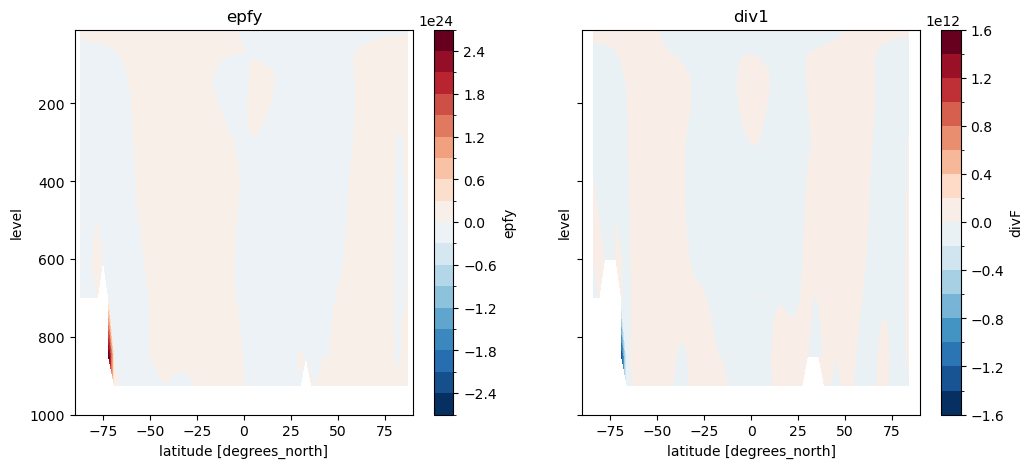

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=xr.SerializationWarning)
    cesm_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/CESM2/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)
    cesm_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/CESM2/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)
    
epfy = cesm_epfy.rename({'plev': 'level'})
ua = cesm_ua.rename({'plev': 'level'})

# match pressure levels to smaller dataset
if len(epfy.level) > len(ua.level):
    epfy = epfy.sel( level = ua.level.values )
else:
    ua = ua.sel( epfy.level.values )

# create dataset and slice to remove spin-up
cesm_ds = xr.Dataset( {'ubar': ua.ua.mean('lon'), 'epfy': epfy.epfy})
cesm_ds['level'] = cesm_ds['level'] / 100
cesm_ds = cesm_ds.interp(lat=np.arange(-90,93,3))
cesm_ds = cesm_ds.sel(time=slice('2000-06', '2001-05'))

# subset epfy to match SRIP datasets
cesm_ds = cesm_ds.where(cesm_ds.level < 1000.)
cesm_ds = cesm_ds.where(cesm_ds.level > 1.)
cesm_ds = cesm_ds.where(cesm_ds.lat > -90.)
cesm_ds = cesm_ds.where(cesm_ds.lat < 90)

# calculate divF
cesm_ds = ef.calculate_divFphi(cesm_ds)

# calculate EFP
cesm_efp_south = ef.calculate_efp_pamip(cesm_ds, calc_south_hemis=True)
cesm_efp = ef.calculate_efp_pamip(cesm_ds)
print(f'CESM2 DJF Feedback: {cesm_efp}')
print(f'CESM2 JAS Feedback: {cesm_efp_south}')

# plot original variables
cesm_ds1 = cesm_ds.sel(level=slice(1000,10))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
cesm_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
cesm_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

### CESM2 with corrections

Strangely, doesn't make much of a difference when removing the huge values...

CESM2 DJF Feedback: 0.3978
CESM2 JAS Feedback: 0.3548


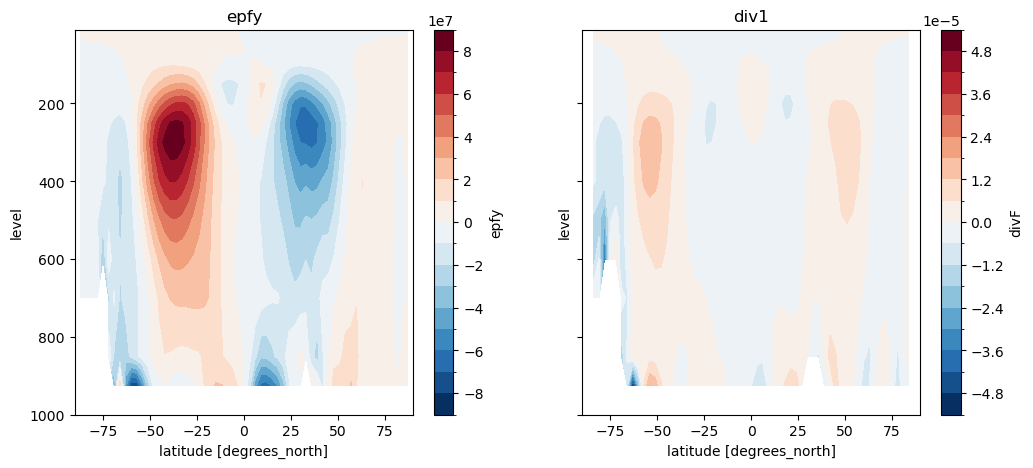

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=xr.SerializationWarning)
    cesm_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/CESM2/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)
    cesm_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/CESM2/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)
    
epfy = cesm_epfy.rename({'plev': 'level'})
ua = cesm_ua.rename({'plev': 'level'})

# match pressure levels to smaller dataset
if len(epfy.level) > len(ua.level):
    epfy = epfy.sel( level = ua.level.values )
else:
    ua = ua.sel( level = epfy.level.values )

# create dataset and slice to remove spin-up
cesm_ds = xr.Dataset( {'ubar': ua.ua.mean('lon'), 'epfy': epfy.epfy})
cesm_ds['level'] = cesm_ds['level'] / 100
cesm_ds = cesm_ds.interp(lat=np.arange(-90,93,3))
cesm_ds = cesm_ds.sel(time=slice('2000-06', '2001-05'))

# subset epfy to match SRIP datasets
cesm_ds = cesm_ds.where(cesm_ds.level < 1000.)
cesm_ds = cesm_ds.where(cesm_ds.level > 1.)
cesm_ds = cesm_ds.where(cesm_ds.lat > -90.)
cesm_ds = cesm_ds.where(cesm_ds.lat < 90)

# REMOVE HUGE VALUES
cesm_ds = cesm_ds.where( abs(cesm_ds.epfy) < 1e10 )

# calculate divF
cesm_ds = ef.calculate_divFphi(cesm_ds)

# calculate EFP
cesm_efp_south = ef.calculate_efp_pamip(cesm_ds, calc_south_hemis=True)
cesm_efp = ef.calculate_efp_pamip(cesm_ds)
print(f'CESM2 DJF Feedback: {cesm_efp}')
print(f'CESM2 JAS Feedback: {cesm_efp_south}')

# plot original variables
cesm_ds1 = cesm_ds.sel(level=slice(1000,10))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
cesm_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
cesm_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

# E3SMv1

Needs to be handled individually. See [other notebook](./pamip_model_wrangle.ipynb).

# EC-EARTH3

EC-EARTH3 DJF Feedback: 0.3365
EC-EARTH3 JAS Feedback: 0.348


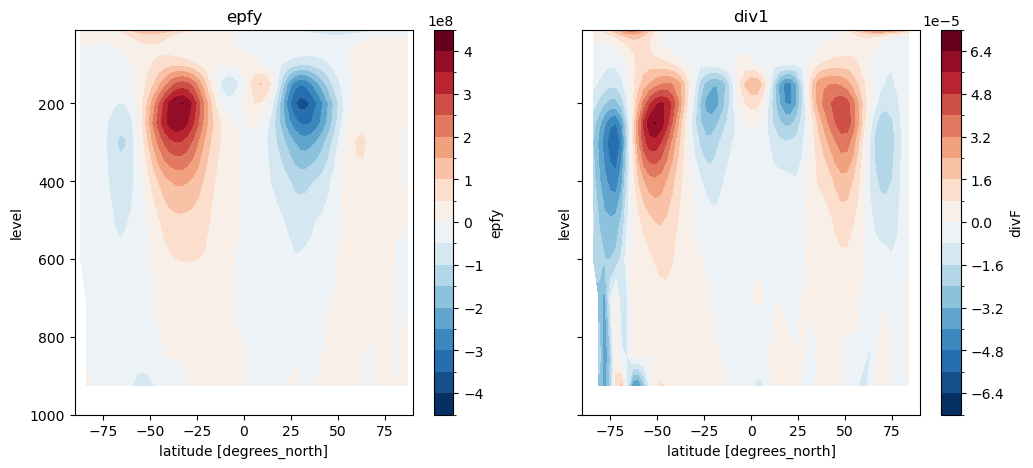

In [9]:
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', category=xr.SerializationWarning)
ec_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/EC-EARTH3/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)
ec_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/EC-EARTH3/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)
    
epfy = ec_epfy.rename({'plev': 'level'})
ua = ec_ua.rename({'plev': 'level'})

epfy = epfy.mean('lon')


# match pressure levels to smaller dataset
if len(epfy.level) > len(ua.level):
    epfy = epfy.sel( level = ua.level.values )
else:
    ua = ua.sel( level = epfy.level.values )

# create dataset and slice to remove spin-up
ec_ds = xr.Dataset( {'ubar': ua.ua.mean('lon'), 'epfy': epfy.epfy})
ec_ds['level'] = ec_ds['level'] / 100
ec_ds = ec_ds.interp(lat=np.arange(-90,93,3))
ec_ds = ec_ds.sel(time=slice('2000-06', '2001-05'))

# subset epfy to match SRIP datasets
ec_ds = ec_ds.where(ec_ds.level < 1000.)
ec_ds = ec_ds.where(ec_ds.level > 1.)
ec_ds = ec_ds.where(ec_ds.lat > -90.)
ec_ds = ec_ds.where(ec_ds.lat < 90)

# calculate divF
ec_ds = ef.calculate_divFphi(ec_ds)

# calculate EFP
ec_efp_south = ef.calculate_efp_pamip(ec_ds, calc_south_hemis=True)
ec_efp = ef.calculate_efp_pamip(ec_ds)
print(f'EC-EARTH3 DJF Feedback: {ec_efp}')
print(f'EC-EARTH3 JAS Feedback: {ec_efp_south}')

# plot original variables
ec_ds1 = ec_ds.sel(level=slice(1000,10))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
ec_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
ec_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

# ECHAM6.3_AWI

Needs to be handled individually. See [other notebook](./pamip_model_wrangle.ipynb).

In [10]:
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', category=xr.SerializationWarning)
awi_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/ECHAM6.3_AWI/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)
awi_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/ECHAM6.3_AWI/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)

awi_epfy = awi_epfy.isel(lon=0)
epfy = awi_epfy.rename({'plev': 'level'})
ua = awi_ua.rename({'plev': 'level'})

# match pressure levels to smaller dataset
if len(epfy.level) > len(ua.level):
    epfy = epfy.sel( level = ua.level.values )
else:
    ua = ua.sel( level = epfy.level.values )

print('Making dataset...')
# create dataset and slice to remove spin-up
awi_ds = xr.Dataset( {'ubar': ua.ua.mean('lon'), 'epfy': epfy.epfy})
awi_ds = awi_ds.chunk({'ens_ax':50, 'lat':96, 'time': 13})
awi_ds

Making dataset...


/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


<xarray.Dataset>
Dimensions:  (time: 26, level: 19, lat: 192, ens_ax: 100)
Coordinates:
  * time     (time) datetime64[ns] 2000-04-16T02:56:00 ... 2001-05-16T14:56:00
  * level    (level) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
    lon      float64 0.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(50, 13, 10, 96), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float64 dask.array<chunksize=(50, 13, 19, 96), meta=np.ndarray>

# FGOALS-f3-L

FGOALS-f3-L DJF Feedback: 0.2621
FGOALS-f3-L JAS Feedback: 0.142


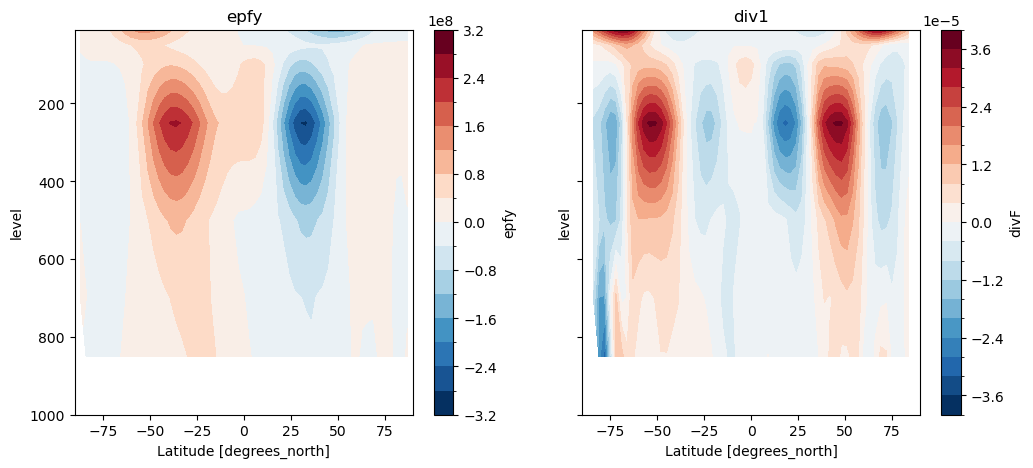

In [11]:
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', category=xr.SerializationWarning)
fgoals_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/FGOALS-f3-L/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)
fgoals_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/FGOALS-f3-L/*.nc', 
                        combine='nested', concat_dim='ens_ax', parallel=True)

epfy = fgoals_epfy.rename({'plev': 'level'})
ua = fgoals_ua.rename({'plev': 'level'})

# match pressure levels to smaller dataset
if len(epfy.level) > len(ua.level):
    epfy = epfy.sel( level = ua.level.values )
else:
    ua = ua.sel( level = epfy.level.values )

# create dataset and slice to remove spin-up
fgoals_ds = xr.Dataset( {'ubar': ua.ua.mean('lon'), 'epfy': epfy.epfy})
fgoals_ds['level'] = fgoals_ds['level'] / 100
fgoals_ds = fgoals_ds.interp(lat=np.arange(-90,93,3))
fgoals_ds = fgoals_ds.sel(time=slice('2000-06', '2001-05'))

# subset epfy to match SRIP datasets
fgoals_ds = fgoals_ds.where(fgoals_ds.level < 1000.)
fgoals_ds = fgoals_ds.where(fgoals_ds.level > 1.)
fgoals_ds = fgoals_ds.where(fgoals_ds.lat > -90.)
fgoals_ds = fgoals_ds.where(fgoals_ds.lat < 90)

# calculate divF
fgoals_ds = ef.calculate_divFphi(fgoals_ds)

# calculate EFP
fgoals_efp_south = ef.calculate_efp_pamip(fgoals_ds, calc_south_hemis=True)
fgoals_efp = ef.calculate_efp_pamip(fgoals_ds)
print(f'FGOALS-f3-L DJF Feedback: {fgoals_efp}')
print(f'FGOALS-f3-L JAS Feedback: {fgoals_efp_south}')

# plot original variables
fgoals_ds1 = fgoals_ds.sel(level=slice(1000,10))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
fgoals_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
fgoals_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

# IPSL-CM6A-LR

1x Dataset - sort individually.

# MIROC6

In [12]:
# miroc_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/MIROC6/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)
# miroc_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/MIROC6/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)

# miroc_epfy = miroc_epfy.sel( plev = miroc_ua.plev.values )
# miroc_ds = xr.Dataset( {'ubar': miroc_ua.ua.mean('lon'), 'epfy': miroc_epfy.epfy})
# miroc_ds = miroc_ds.rename({'plev': 'level'})
# miroc_ds = miroc_ds.sel(time=slice('2000-06', '2001-05'))

miroc_ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/MIROC6*.nc',
                           parallel=True, chunks={'time':12, 'ens_ax':150})
miroc_ds

<xarray.Dataset>
Dimensions:  (ens_ax: 100, time: 12, level: 19, lat: 61)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-16 ... 2001-05-16T12:00:00
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(100, 12, 19, 61), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 dask.array<chunksize=(100, 12, 19, 61), meta=np.ndarray>
    divF     (ens_ax, time, level, lat) float64 dask.array<chunksize=(100, 12, 19, 61), meta=np.ndarray>

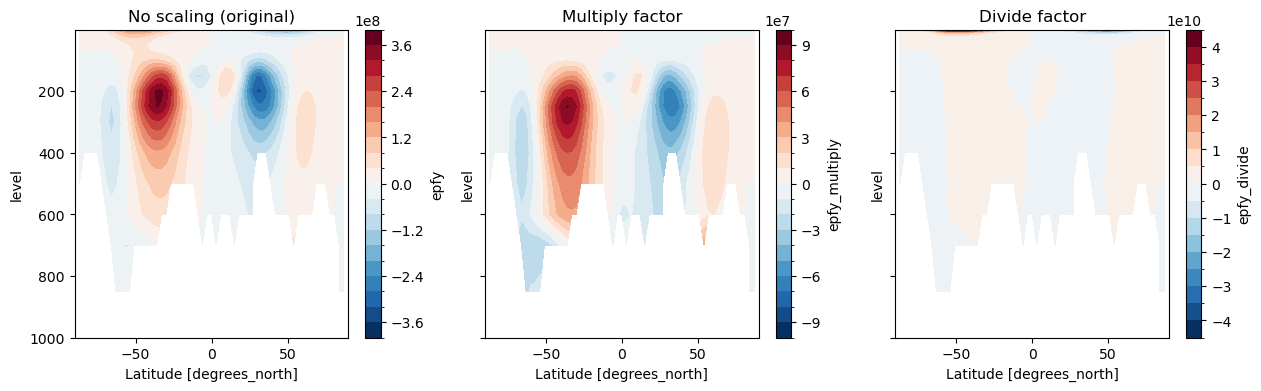

In [13]:
# define factor variables
miroc_ds['epfy_multiply'] = ef.pressure_scaling(miroc_ds['epfy'], multiply_factor=True)
miroc_ds['epfy_divide'] = ef.pressure_scaling(miroc_ds['epfy'], multiply_factor=False)

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
miroc_ds.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
miroc_ds.epfy_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
miroc_ds.epfy_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

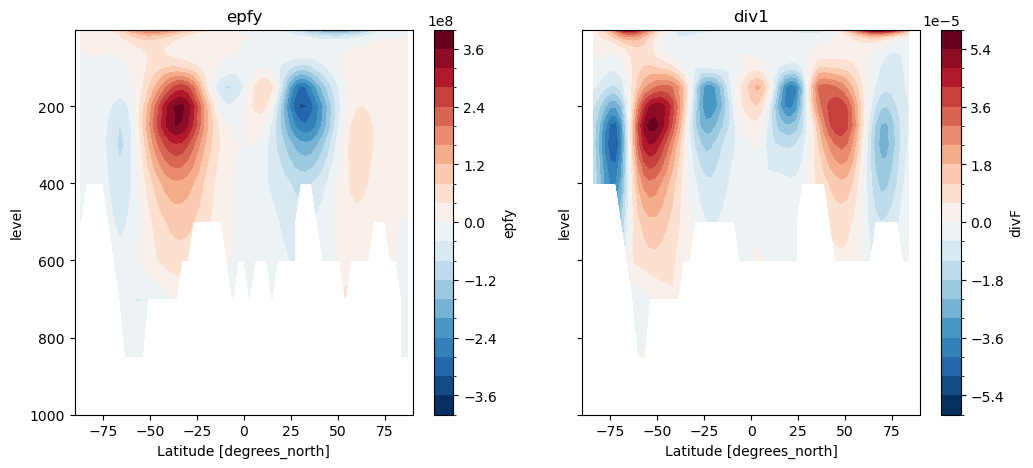

In [14]:
# calculate divFphi and insert into dataset
miroc_ds = ef.calculate_divFphi(miroc_ds, which_Fphi='epfy', apply_scaling=False)
miroc_ds = ef.calculate_divFphi(miroc_ds, which_Fphi='epfy_divide', apply_scaling=False, save_divFphi='divF_divide')
miroc_ds = ef.calculate_divFphi(miroc_ds, which_Fphi='epfy_multiply', apply_scaling=False, save_divFphi='divF_multiply')

# plot original variables
miroc_ds1 = miroc_ds.sel(level=slice(1000,00))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
miroc_ds1.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
miroc_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

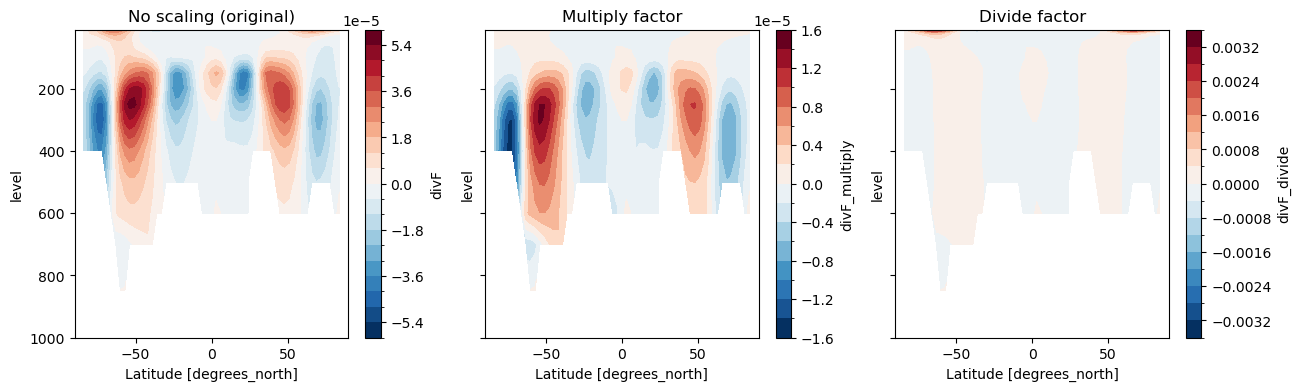

In [15]:
miroc_ds1 = miroc_ds.sel(level=slice(1000., 10.))

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
miroc_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
miroc_ds1.divF_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
miroc_ds1.divF_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

### Eddy Feedback Parameter

In [16]:
# calculate NH EFP
miroc_efp_multiply_south = ef.calculate_efp_pamip(miroc_ds, which_div1='divF_multiply', calc_south_hemis=True)
miroc_efp_divide_south = ef.calculate_efp_pamip(miroc_ds, which_div1='divF_divide', calc_south_hemis=True)
miroc_efp_south = ef.calculate_efp_pamip(miroc_ds, calc_south_hemis=True)

# calculate SH EFP
miroc_efp_multiply = ef.calculate_efp_pamip(miroc_ds, which_div1='divF_multiply')
miroc_efp_divide = ef.calculate_efp_pamip(miroc_ds, which_div1='divF_divide')
miroc_efp = ef.calculate_efp_pamip(miroc_ds)

print('MIROC6 DJF Feedback:\n')
print(f'Multiplying factor: {miroc_efp_multiply} \nDividing factor: {miroc_efp_divide} \nNo factor: {miroc_efp}')
print('\nMIROC6 JAS Feedback:\n')
print(f'Multiplying factor: {miroc_efp_multiply_south} \nDividing factor: {miroc_efp_divide_south} \nNo factor: {miroc_efp_south}')

MIROC6 DJF Feedback:

Multiplying factor: 0.2469 
Dividing factor: 0.2469 
No factor: 0.2469

MIROC6 JAS Feedback:

Multiplying factor: 0.3547 
Dividing factor: 0.3547 
No factor: 0.3547


# NorESM2-LM

In [17]:
# nor_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/NorESM2-LM/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)
# nor_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/NorESM2-LM/*.nc', 
#                          combine='nested', concat_dim='ens_ax', parallel=True)

# nor_epfy = nor_epfy.sel( plev = nor_ua.plev.values )
# nor_ds = xr.Dataset( {'ubar': nor_ua.ua.mean('lon'), 'epfy': nor_epfy.epfy})
# nor_ds = nor_ds.rename({'plev': 'level'})
# nor_ds = nor_ds.sel(time=slice('2000-06', '2001-05'))
nor_ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/Nor*.nc',
                           parallel=True, chunks={'time':12, 'ens_ax':150})
nor_ds

<xarray.Dataset>
Dimensions:  (ens_ax: 200, time: 12, level: 19, lat: 61)
Coordinates:
  * time     (time) object 2000-06-16 00:00:00 ... 2001-05-16 12:00:00
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>
    divF     (ens_ax, time, level, lat) float64 dask.array<chunksize=(150, 12, 19, 61), meta=np.ndarray>

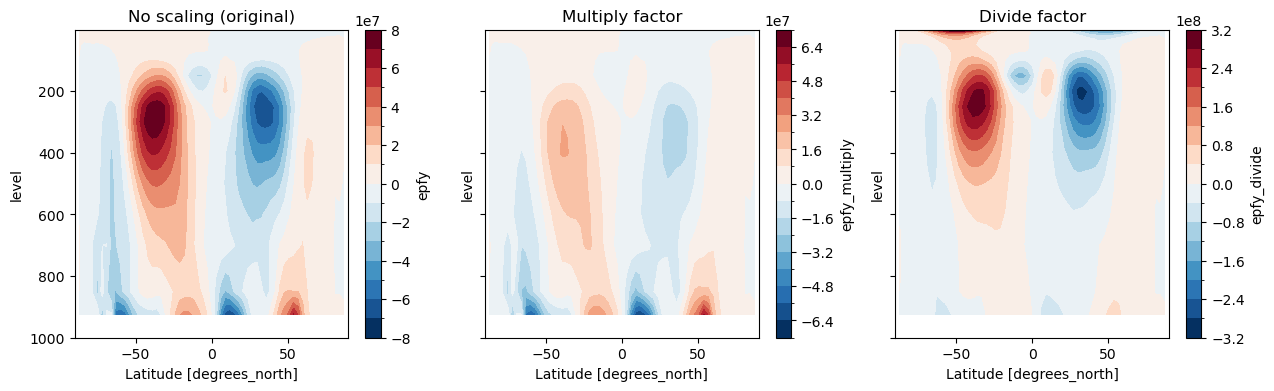

In [18]:
# define factor variables
nor_ds['epfy_multiply'] = ef.pressure_scaling(nor_ds['epfy'], multiply_factor=True)
nor_ds['epfy_divide'] = ef.pressure_scaling(nor_ds['epfy'], multiply_factor=False)

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
nor_ds.epfy.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
nor_ds.epfy_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
nor_ds.epfy_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

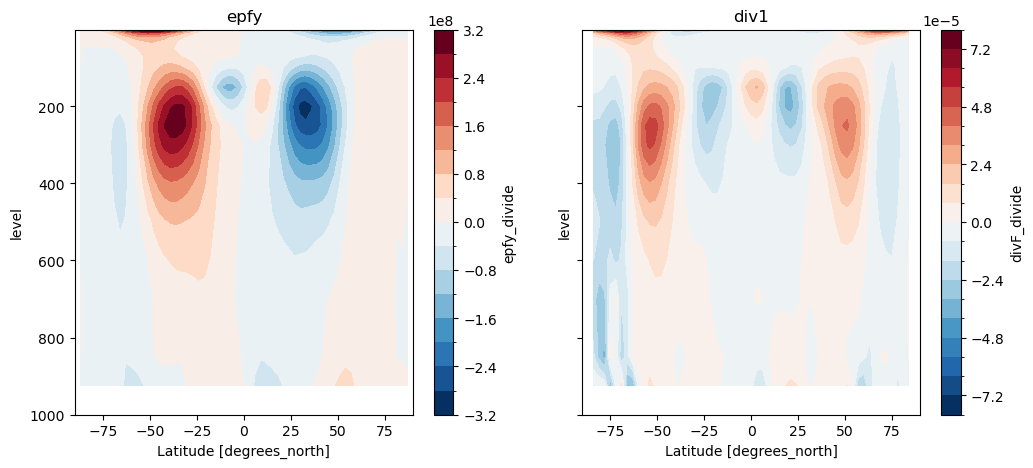

In [19]:
# calculate divFphi and insert into dataset
nor_ds = ef.calculate_divFphi(nor_ds, which_Fphi='epfy', apply_scaling=False)
nor_ds = ef.calculate_divFphi(nor_ds, which_Fphi='epfy_divide', apply_scaling=False, save_divFphi='divF_divide')
nor_ds = ef.calculate_divFphi(nor_ds, which_Fphi='epfy_multiply', apply_scaling=False, save_divFphi='divF_multiply')

# plot original variables
# nor_ds = nor_ds.sel(level=slice(100000,1000))     # Pa
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
nor_ds.epfy_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
nor_ds.divF_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy')
ax2.set_title('div1')
plt.show()

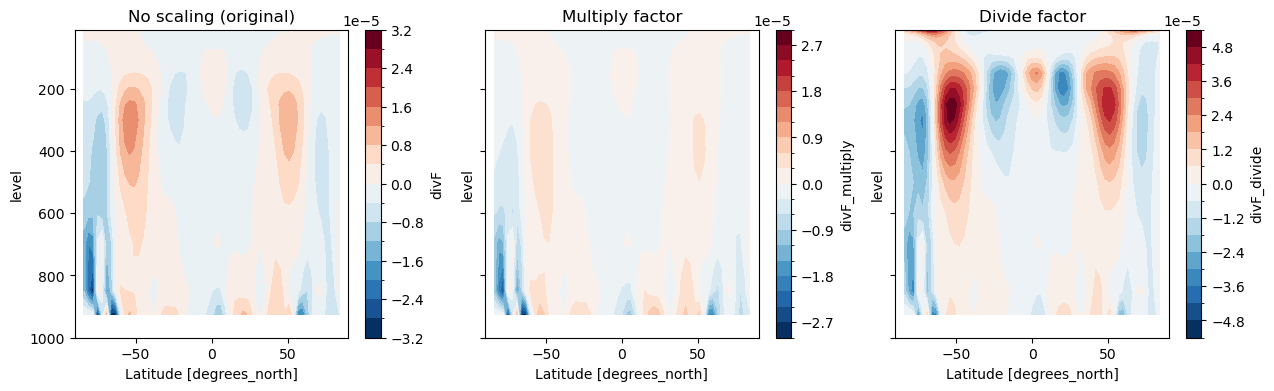

In [20]:
nor_ds1 = nor_ds.sel(level=slice(1000., 10.))

# plot vars for comparison
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,4))
nor_ds1.divF.mean(('time', 'ens_ax')).plot.contourf(ax=ax1, levels=20, yincrease=False)
nor_ds1.divF_multiply.mean(('time', 'ens_ax')).plot.contourf(ax=ax2, levels=20, yincrease=False)
nor_ds1.divF_divide.mean(('time', 'ens_ax')).plot.contourf(ax=ax3, levels=20, yincrease=False)
ax1.set_title('No scaling (original)')
ax2.set_title('Multiply factor')
ax3.set_title('Divide factor')
plt.show()

### Eddy Feedback Parameter

In [21]:
# calculate NH EFP
nor_efp_multiply_south = ef.calculate_efp_pamip(nor_ds, which_div1='divF_multiply', calc_south_hemis=True)
nor_efp_divide_south = ef.calculate_efp_pamip(nor_ds, which_div1='divF_divide', calc_south_hemis=True)
nor_efp_south = ef.calculate_efp_pamip(nor_ds, calc_south_hemis=True)

# calculate SH EFP
nor_efp_multiply = ef.calculate_efp_pamip(nor_ds, which_div1='divF_multiply')
nor_efp_divide = ef.calculate_efp_pamip(nor_ds, which_div1='divF_divide')
nor_efp = ef.calculate_efp_pamip(nor_ds)

print('NorESM2-LM DJF Feedback:\n')
print(f'Multiplying factor: {nor_efp_multiply} \nDividing factor: {nor_efp_divide} \nNo factor: {nor_efp}')
print('\nNorESM2-LM JAS Feedback:\n')
print(f'Multiplying factor: {nor_efp_multiply_south} \nDividing factor: {nor_efp_divide_south} \nNo factor: {nor_efp_south}')

NorESM2-LM DJF Feedback:

Multiplying factor: 0.3354 
Dividing factor: 0.3354 
No factor: 0.3354

NorESM2-LM JAS Feedback:

Multiplying factor: 0.3837 
Dividing factor: 0.3837 
No factor: 0.3837


: 